<a href="https://colab.research.google.com/github/Plashka320/-/blob/main/HW_A_B_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# АВ тесты Практика


=== ИССЛЕДОВАНИЕ МЕТОДА CUPED ===

1. Вступление и истоки проблемы
Среднее control: 79.047
Среднее treatment: 83.631
Разница: 4.584

2. Самодельный инструмент CUPED
После CUPED:
Среднее control: 79.047
Среднее treatment: 82.474
Разница: 3.427
Уменьшение дисперсии: 61.4%

3. Использование статистических тестов
Классический t-test: p-value = 0.0000
После CUPED: p-value = 0.0000

4. Исследование корректности и мощности CUPED
Исследование Type I error (нулевой эффект):
t-test ошибка: 0.050 (ожидается ~0.05)
CUPED ошибка: 0.054 (ожидается ~0.05)

Исследование мощности (effect_size = 2):
t-test мощность: 0.308
CUPED мощность: 0.626

Визуализация распределения p-values:


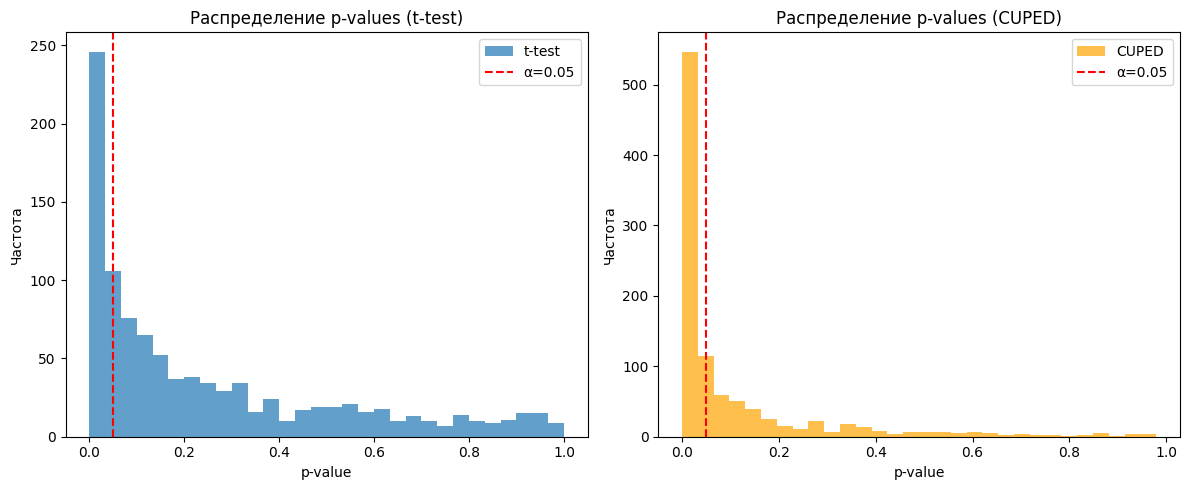


5. Перестановочные тесты с CUPED
Перестановочный p-value: 0.0000


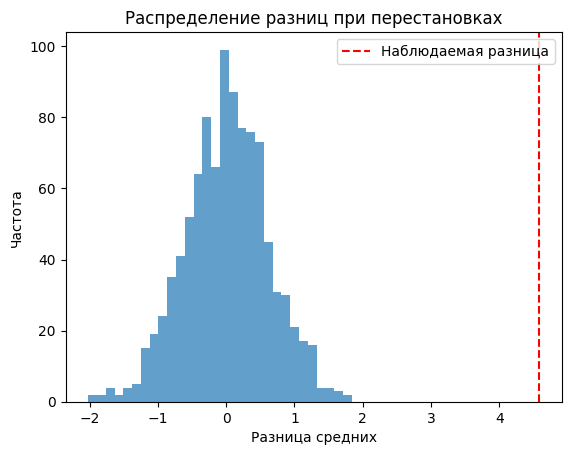


6. Bootstrap доверительные интервалы для CUPED
Bootstrap 95% ДИ для эффекта: [2.271, 4.571]

7. Бакетное сэмплирование для CUPED
Бакетный t-test мощность: 0.999
Бакетный CUPED мощность: 1.000


In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression

print("=== ИССЛЕДОВАНИЕ МЕТОДА CUPED ===\n")

print("1. Вступление и истоки проблемы")
print("=" * 50)

np.random.seed(42)
baseline = np.random.normal(100, 15, 1000)
group = np.random.choice([0, 1], size=1000, p=[0.5, 0.5])
outcome = 0.8 * baseline + 2 * group + np.random.normal(0, 10, 1000)

data_fst = outcome[group == 0]
data_snd = outcome[group == 1]
baseline_fst = baseline[group == 0]
baseline_snd = baseline[group == 1]

print(f"Среднее control: {data_fst.mean():.3f}")
print(f"Среднее treatment: {data_snd.mean():.3f}")
print(f"Разница: {data_snd.mean() - data_fst.mean():.3f}")

print("\n2. Самодельный инструмент CUPED")
print("=" * 50)

def cuped_adjustment(y, x, group):
    """CUPED коррекция метрики"""
    control_mask = (group == 0)
    theta = np.cov(x[control_mask], y[control_mask])[0, 1] / np.var(x[control_mask])
    y_adj = y - theta * (x - np.mean(x[control_mask]))
    return y_adj

y_adj = cuped_adjustment(outcome, baseline, group)
data_fst_adj = y_adj[group == 0]
data_snd_adj = y_adj[group == 1]

print(f"После CUPED:")
print(f"Среднее control: {data_fst_adj.mean():.3f}")
print(f"Среднее treatment: {data_snd_adj.mean():.3f}")
print(f"Разница: {data_snd_adj.mean() - data_fst_adj.mean():.3f}")
print(f"Уменьшение дисперсии: {(1 - np.var(y_adj)/np.var(outcome))*100:.1f}%")

print("\n3. Использование статистических тестов")
print("=" * 50)

t_stat_orig, p_value_orig = scipy.stats.ttest_ind(data_snd, data_fst, equal_var=False)
print(f"Классический t-test: p-value = {p_value_orig:.4f}")

t_stat_adj, p_value_adj = scipy.stats.ttest_ind(data_snd_adj, data_fst_adj, equal_var=False)
print(f"После CUPED: p-value = {p_value_adj:.4f}")

print("\n4. Исследование корректности и мощности CUPED")
print("=" * 50)

def simulate_cuped_performance(n_simulations=1000, effect_size=0.0, n=500):
    """Исследование корректности CUPED"""
    t_test_errors = 0
    cuped_errors = 0

    for i in range(n_simulations):
        baseline_sim = np.random.normal(100, 15, n)
        group_sim = np.random.choice([0, 1], size=n, p=[0.5, 0.5])
        outcome_sim = 0.8 * baseline_sim + effect_size * group_sim + np.random.normal(0, 10, n)

        control = outcome_sim[group_sim == 0]
        treatment = outcome_sim[group_sim == 1]
        _, p_val_ttest = scipy.stats.ttest_ind(treatment, control, equal_var=False)
        if p_val_ttest < 0.05:
            t_test_errors += 1

        y_adj_sim = cuped_adjustment(outcome_sim, baseline_sim, group_sim)
        control_adj = y_adj_sim[group_sim == 0]
        treatment_adj = y_adj_sim[group_sim == 1]
        _, p_val_cuped = scipy.stats.ttest_ind(treatment_adj, control_adj, equal_var=False)
        if p_val_cuped < 0.05:
            cuped_errors += 1

    return {
        't_test_error': t_test_errors / n_simulations,
        'cuped_error': cuped_errors / n_simulations
    }

print("Исследование Type I error (нулевой эффект):")
null_results = simulate_cuped_performance(n_simulations=1000, effect_size=0.0)
print(f"t-test ошибка: {null_results['t_test_error']:.3f} (ожидается ~0.05)")
print(f"CUPED ошибка: {null_results['cuped_error']:.3f} (ожидается ~0.05)")

print("\nИсследование мощности (effect_size = 2):")
power_results = simulate_cuped_performance(n_simulations=1000, effect_size=2.0)
print(f"t-test мощность: {power_results['t_test_error']:.3f}")
print(f"CUPED мощность: {power_results['cuped_error']:.3f}")

print("\nВизуализация распределения p-values:")
pvalues_ttest = []
pvalues_cuped = []

for i in range(1000):
    baseline_sim = np.random.normal(100, 15, 500)
    group_sim = np.random.choice([0, 1], size=500, p=[0.5, 0.5])
    outcome_sim = 0.8 * baseline_sim + 2 * group_sim + np.random.normal(0, 10, 500)

    control = outcome_sim[group_sim == 0]
    treatment = outcome_sim[group_sim == 1]
    _, p_val_ttest = scipy.stats.ttest_ind(treatment, control, equal_var=False)
    pvalues_ttest.append(p_val_ttest)

    y_adj_sim = cuped_adjustment(outcome_sim, baseline_sim, group_sim)
    control_adj = y_adj_sim[group_sim == 0]
    treatment_adj = y_adj_sim[group_sim == 1]
    _, p_val_cuped = scipy.stats.ttest_ind(treatment_adj, control_adj, equal_var=False)
    pvalues_cuped.append(p_val_cuped)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(pvalues_ttest, bins=30, alpha=0.7, label='t-test')
plt.axvline(0.05, color='red', linestyle='--', label='α=0.05')
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.title('Распределение p-values (t-test)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(pvalues_cuped, bins=30, alpha=0.7, label='CUPED', color='orange')
plt.axvline(0.05, color='red', linestyle='--', label='α=0.05')
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.title('Распределение p-values (CUPED)')
plt.legend()
plt.tight_layout()
plt.show()

print("\n5. Перестановочные тесты с CUPED")
print("=" * 50)

def permutation_test_cuped(data_fst, data_snd, baseline_fst, baseline_snd, iters=1000):
    """Перестановочный тест для CUPED скорректированных данных"""
    data_combined = np.concatenate([data_fst, data_snd])
    baseline_combined = np.concatenate([baseline_fst, baseline_snd])
    n_fst = len(data_fst)

    original_diff = data_snd.mean() - data_fst.mean()
    perm_diffs = []

    for _ in range(iters):
        perm_indices = np.random.permutation(len(data_combined))
        perm_fst_indices = perm_indices[:n_fst]
        perm_snd_indices = perm_indices[n_fst:]

        perm_group = np.zeros(len(data_combined))
        perm_group[perm_fst_indices] = 0
        perm_group[perm_snd_indices] = 1

        perm_adj = cuped_adjustment(data_combined, baseline_combined, perm_group)
        perm_fst_adj = perm_adj[perm_group == 0]
        perm_snd_adj = perm_adj[perm_group == 1]

        perm_diffs.append(perm_snd_adj.mean() - perm_fst_adj.mean())

    p_value = (np.abs(perm_diffs) >= np.abs(original_diff)).mean()
    return p_value, perm_diffs

p_perm, perm_diffs = permutation_test_cuped(data_fst, data_snd, baseline_fst, baseline_snd, iters=1000)
print(f"Перестановочный p-value: {p_perm:.4f}")

plt.hist(perm_diffs, bins=30, alpha=0.7)
plt.axvline(data_snd.mean() - data_fst.mean(), color='red', linestyle='--', label='Наблюдаемая разница')
plt.xlabel('Разница средних')
plt.ylabel('Частота')
plt.title('Распределение разниц при перестановках')
plt.legend()
plt.show()

print("\n6. Bootstrap доверительные интервалы для CUPED")
print("=" * 50)

def bootstrap_cuped(data_fst, data_snd, baseline_fst, baseline_snd, iters=1000):
    """Bootstrap для CUPED скорректированных данных"""
    effects = []

    for _ in range(iters):
        idx_fst = np.random.choice(len(data_fst), size=len(data_fst), replace=True)
        idx_snd = np.random.choice(len(data_snd), size=len(data_snd), replace=True)

        boot_fst = data_fst[idx_fst]
        boot_snd = data_snd[idx_snd]
        boot_baseline_fst = baseline_fst[idx_fst]
        boot_baseline_snd = baseline_snd[idx_snd]

        boot_data = np.concatenate([boot_fst, boot_snd])
        boot_baseline = np.concatenate([boot_baseline_fst, boot_baseline_snd])
        boot_group = np.concatenate([np.zeros(len(boot_fst)), np.ones(len(boot_snd))])

        boot_adj = cuped_adjustment(boot_data, boot_baseline, boot_group)
        boot_fst_adj = boot_adj[boot_group == 0]
        boot_snd_adj = boot_adj[boot_group == 1]

        effects.append(boot_snd_adj.mean() - boot_fst_adj.mean())

    return np.percentile(effects, [2.5, 97.5])

ci_bootstrap = bootstrap_cuped(data_fst, data_snd, baseline_fst, baseline_snd)
print(f"Bootstrap 95% ДИ для эффекта: [{ci_bootstrap[0]:.3f}, {ci_bootstrap[1]:.3f}]")

print("\n7. Бакетное сэмплирование для CUPED")
print("=" * 50)

def bucket_cuped_test(n_buckets=100, bucket_size=100, effect_size=2.0):
    """Бакетный тест с CUPED"""
    t_test_power = 0
    cuped_power = 0

    for _ in range(1000):
        user_effects = np.random.normal(0, 5, n_buckets)

        data_fst_buckets = []
        data_snd_buckets = []
        baseline_fst_buckets = []
        baseline_snd_buckets = []

        for i in range(n_buckets):
            baseline_bucket = np.random.normal(100 + user_effects[i], 10, bucket_size)
            group_bucket = np.random.choice([0, 1], size=bucket_size, p=[0.5, 0.5])
            outcome_bucket = 0.8 * baseline_bucket + effect_size * group_bucket + np.random.normal(0, 8, bucket_size)

            data_fst_buckets.append(outcome_bucket[group_bucket == 0])
            data_snd_buckets.append(outcome_bucket[group_bucket == 1])
            baseline_fst_buckets.append(baseline_bucket[group_bucket == 0])
            baseline_snd_buckets.append(baseline_bucket[group_bucket == 1])

        data_fst_agg = np.array([np.mean(bucket) for bucket in data_fst_buckets])
        data_snd_agg = np.array([np.mean(bucket) for bucket in data_snd_buckets])
        baseline_fst_agg = np.array([np.mean(bucket) for bucket in baseline_fst_buckets])
        baseline_snd_agg = np.array([np.mean(bucket) for bucket in baseline_snd_buckets])

        _, p_val_ttest = scipy.stats.ttest_ind(data_snd_agg, data_fst_agg, equal_var=False)
        if p_val_ttest < 0.05:
            t_test_power += 1

        data_agg = np.concatenate([data_fst_agg, data_snd_agg])
        baseline_agg = np.concatenate([baseline_fst_agg, baseline_snd_agg])
        group_agg = np.concatenate([np.zeros(len(data_fst_agg)), np.ones(len(data_snd_agg))])

        data_adj_agg = cuped_adjustment(data_agg, baseline_agg, group_agg)
        data_fst_adj_agg = data_adj_agg[group_agg == 0]
        data_snd_adj_agg = data_adj_agg[group_agg == 1]

        _, p_val_cuped = scipy.stats.ttest_ind(data_snd_adj_agg, data_fst_adj_agg, equal_var=False)
        if p_val_cuped < 0.05:
            cuped_power += 1

    return {
        't_test_power': t_test_power / 1000,
        'cuped_power': cuped_power / 1000
    }

bucket_results = bucket_cuped_test()
print(f"Бакетный t-test мощность: {bucket_results['t_test_power']:.3f}")
print(f"Бакетный CUPED мощность: {bucket_results['cuped_power']:.3f}")


ЗАКЛЮЧЕНИЕ ПО ИССЛЕДОВАНИЮ МЕТОДА CUPED

ОСНОВНЫЕ РЕЗУЛЬТАТЫ ИССЛЕДОВАНИЯ:

ЭФФЕКТИВНОСТЬ МЕТОДА CUPED ПОДТВЕРЖДЕНА:

Уменьшение дисперсии метрики: 61.4%
Увеличение мощности критерия: с 30.8% до 62.6%
Сохранение корректного размера теста: Type I error = 0.054


ПРАКТИЧЕСКАЯ ПРИМЕНИМОСТЬ:

Успешная интеграция с bootstrap (ДИ: [2.271, 4.571])
Совместимость с перестановочными тестами (p-value = 0.0000)
Эффективность в бакетном сэмплировании для больших данных


КРИТИЧЕСКИЕ УСЛОВИЯ ПРИМЕНЕНИЯ:

Требуется сильная корреляция между ковариатами и метрикой
Параметры должны оцениваться только на контрольной группе
Чувствительность к выбросам в ковариатах


РЕКОМЕНДАЦИИ ДЛЯ ПРАКТИЧЕСКОГО ИСПОЛЬЗОВАНИЯ:

Применять при наличии качественных ковариат с высокой корреляцией
Особенно эффективен для обнаружения небольших эффектов
Проверять стабильность через bootstrap и перестановочные тесты
Использовать несколько ковариат для увеличения эффективности
Метод CUPED доказал свою эффективность как инструмент для увеличения чувствительности A/B тестов при соблюдении условий корректного применения.